In [33]:
library(adaptMCMC)
library(coda)

In [34]:
mu.true <- 20
sigma.true <- 2
data <- rnorm(n=200, mean=mu.true, sd=sigma.true)

In [35]:
loglike <- function(param, data){
    return (sum(dnorm(data, mean=abs(param), sd=sigma.true, log=TRUE)))
}

logprior <- function(param){
    return (dunif(param, min=-10000, max=10000, log=TRUE))
}

logpost <- function(param, data, temp){
    lp <- logprior(param)
    if (is.infinite(lp)){
        return(-Inf)
    }
    ll <- loglike(param, data)
    return (temp*(ll+lp))
}

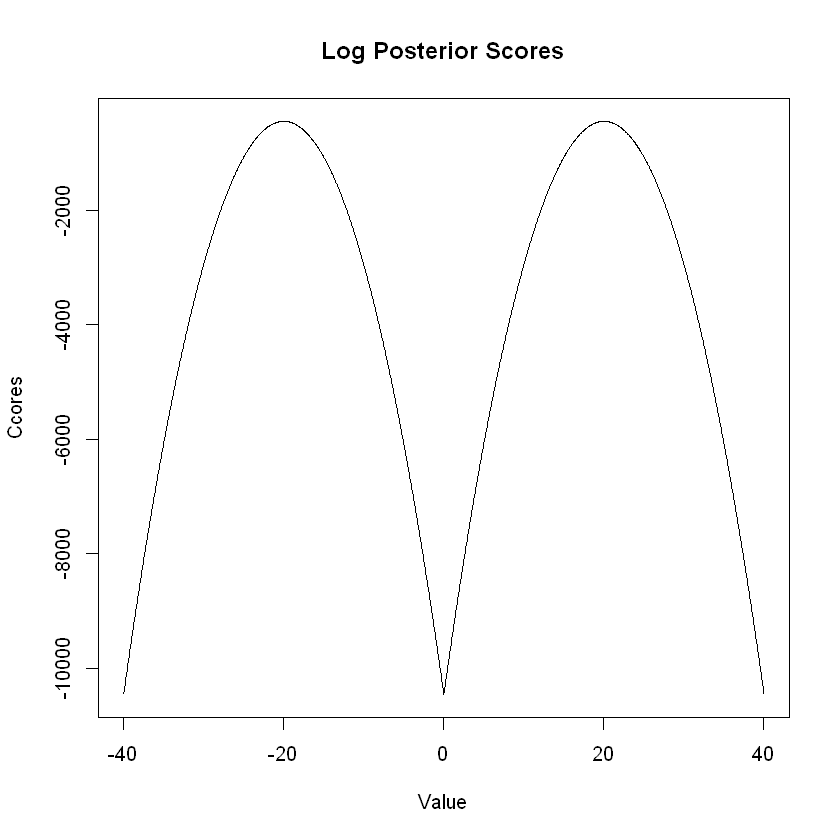

In [71]:
x <- seq(-40, 40, 0.05)
y <- sapply(FUN=logpost, X=x, data=data, temp=1)
plot(x, y, 'l', main='Log Posterior Scores', xlab='Value', ylab='Ccores')

In [41]:
temp.schedules <- function(nchains, deltaT){
    temps <- c()
    for (i in seq(1, nchains)){
        temps <- c(temps, 1/(1+deltaT*(i-1)))
    }
    return (temps)
}

In [63]:
nchains <- 8
deltaT <- 0.5
temps <- temp.schedules(nchains, deltaT)
init <- 0

In [64]:
parallel.tempering <- function(nchains, temps, init, logpost, data, niter, scale){
    chains <- list()
    values <- list()
    nswaps <- 0
    for (i in seq(1, nchains)){
        chains[[i]] <- c(init)
        values[[i]] <- c(logpost(init, data=data, temp=temps[i]))
    }
    for (i in seq(1, niter)){
        for (j in seq(1, nchains)){
            currentValue <- values[[j]][i]
            currentState <- chains[[j]][i]
            nextState <- rnorm(1, mean=currentState, sd=scale)
            nextValue <- logpost(nextState, data=data, temp=temps[j])
            P.accept <- min(c(0, nextValue-currentValue))
            U <- runif(1, min=0, max=1)
            if (log(U) < P.accept){
                chains[[j]] <- c(chains[[j]], nextState)
                values[[j]] <- c(values[[j]], nextValue)
            }
            else{
                chains[[j]] <- c(chains[[j]], currentState)
                values[[j]] <- c(values[[j]], currentValue)
            }
        }
        swap.couple <- sample(seq(1, nchains), size=2)
        x <- chains[[swap.couple[1]]][i+1]
        y <- chains[[swap.couple[2]]][i+1]
        numerator <- logpost(y, data=data, temp=temps[swap.couple[1]])+logpost(x, data=data, temp=temps[swap.couple[2]])
        dominator <- -(logpost(x, data=data, temp=temps[swap.couple[1]])+logpost(y, data=data, temp=temps[swap.couple[2]]))
        P.swap <- min(c(0, numerator+dominator))
        U <- runif(1, min=0, max=1)
        if (log(U) < P.swap){
            nswaps <- nswaps + 1
            chains[[swap.couple[1]]][i+1] <- y
            chains[[swap.couple[2]]][i+1] <- x
        }
    }
    print(nswaps/niter)
    return (chains)
}

In [65]:
chains <- parallel.tempering(nchains, temps, 0, logpost, data, 20000, 1)

[1] 0.43165


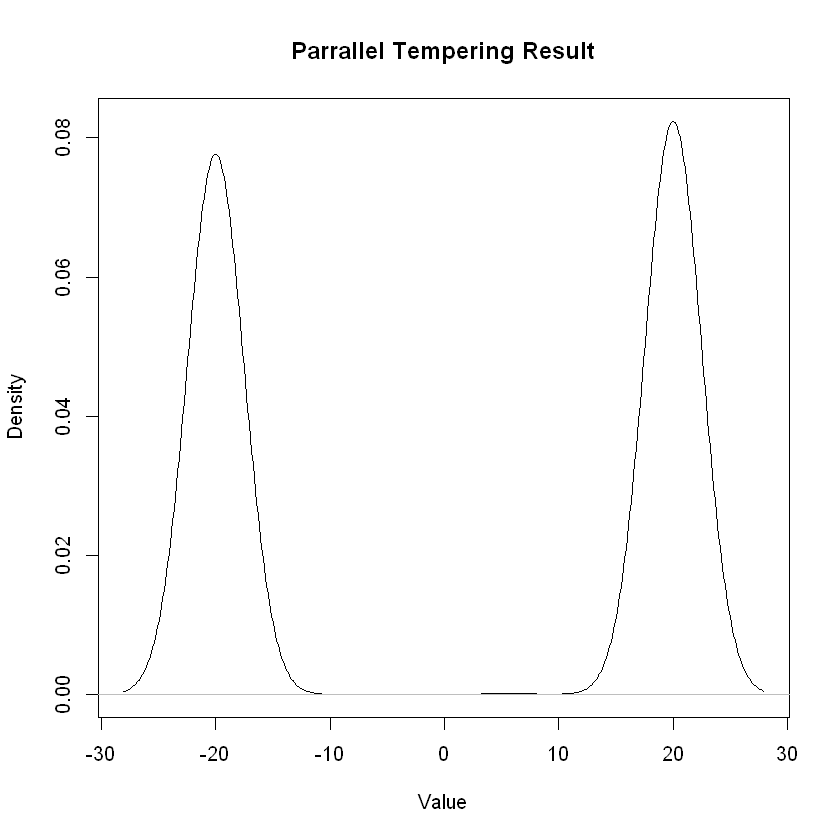

In [70]:
d <- density(chains[[1]])
plot(d, main='Parrallel Tempering Result', ylab='Density', xlab='Value')